# Implementation of NLU component of a chatbot

In this assignment you will build an application that performs __intent classification__ and __slot filling__, which are the core tasks that take care the **NLU module** in any chatbot. 

*   __intent classification__ consist in mapping user utterance (typically a 
customer) into a predefined set of _intents_ (goals of the user) so the computer can know what she is asking.

* __slot filling__ consist in extracting filler values from the uterance of the user. 

The example below show a user command asking a flight ticket to fly from Boston to Denver, departing at 8:38 and arriving at 11:10. The goal is to extrac all this information automatically. 

![](https://drive.google.com/uc?export=view&id=1cWS1ybRPMGladx3qv8G4th5fyZO3cA-h)


We will use the [ATIS (Airline Travel Information Systems) dataset](https://www.aclweb.org/anthology/H90-1021.pdf), which is  a dataset consisting of audio recordings and corresponding manual transcripts about humans asking for flight information on automated airline travel inquiry systems. The data consists of 17 unique intent categories, and 81 slots in total. 

The main goal of the assigment is to build a system that perform intent detection and slot filing. We define a list steps you can folllow to complete the assignemnt. The steps are the following:
- Preprocess the data.
- Implement the models for intent classification and slot filling.
- Evaluate proposed model.
- Run some analysis of the model output.

Note you are not requiered to strictly follow the steps suggested in the notebook as long as you build a model, evaluate it and provide some analysis.


## Some utils
We provide some utilities that can be useful for the assignments. You are not obligated to use them, but depending on you model (e.g. CRF, LSTM, or BERT), it might be a good idea to use them. Also, it might faster to  

We provide two 


In [1]:
import pandas as pd

# helper function to read dev and test data format (use get_data2 for training)
def get_data(filename):
    df = pd.read_csv(filename, delim_whitespace=True, names=['word', 'label'])
    beg_indices = list(df[df['word'] == 'BOS'].index)+[df.shape[0]]
    sents, labels, intents = [], [], []
    for i in range(len(beg_indices[:-1])):
        sents.append(df[beg_indices[i]+1:beg_indices[i+1]-1]['word'].values)
        labels.append(df[beg_indices[i]+1:beg_indices[i+1]-1]['label'].values)
        intents.append(df.loc[beg_indices[i+1]-1]['label'])    
    return sents, labels, intents

# helper function to read training data format
def get_data2(filename):
    with open(filename) as f:
        contents = f.read()
    sents, labels, intents = [],[],[]
    for line in contents.strip().split('\n'):
        words, labs = [i.split(' ') for i in line.split('\t')]
        sents.append(words[1:-1])
        labels.append(labs[1:-1])
        intents.append(labs[-1])
    return sents, labels, intents

## Load the data and understand it

First thing you need to do is to understand the different aspects of the your data, such as knowing how the information is formated, the number of examples we have to train, validate and test our models, what is the distribution of labels, and so on. 

### TO-DO
Using your own code or the one provided above load the data and run some small analysis. For example, it is a good idea to print some statistics: 

- Number of examples for each partition
- Class distribution for intent classification
- Class distribution for slot filling task. 
- Do we have same set of slot labels for each intent type? 

Additionally, it is also good idea to create some plots of the statistics. 

In [2]:
# Here I mounted the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Here I Specifed file paths
train_file=  '/content/drive/MyDrive/atis-20230603T182700Z-001/atis/atis-2.train.w-intent.iob'
dev_file= '/content/drive/MyDrive/atis-20230603T182700Z-001/atis/atis-2.dev.w-intent.iob'
test_file= '/content/drive/MyDrive/atis-20230603T182700Z-001/atis/atis.test.w-intent.iob'

train_texts, train_slots, train_intents = get_data2(train_file)
dev_texts, dev_slots, dev_intents = get_data(dev_file)
test_text, test_slots, test_intents = get_data(test_file)

In [4]:
#Here I Printed the example data from the training set
print(train_texts[0])
print(train_slots[0])
print(train_intents[0])

['i', 'want', 'to', 'fly', 'from', 'baltimore', 'to', 'dallas', 'round', 'trip']
['O', 'O', 'O', 'O', 'O', 'B-fromloc.city_name', 'O', 'B-toloc.city_name', 'B-round_trip', 'I-round_trip']
atis_flight


In [5]:
# Here Print  the example data from the dev set
print (dev_texts[1])

['show' 'me' 'all' 'round' 'trip' 'flights' 'between' 'houston' 'and'
 'las' 'vegas']


In [6]:
import matplotlib.pyplot as plt

# Here I Load the data
train_texts, train_slots, train_intents = get_data2(train_file)
dev_texts, dev_slots, dev_intents = get_data(dev_file)
test_texts, test_slots, test_intents = get_data(test_file)

# Here the Number of examples for each partition
print("Number of examples:")
print("Train examples:", len(train_texts))
print("Dev examples:", len(dev_texts))
print("Test examples:", len(test_texts))

Number of examples:
Train examples: 4478
Dev examples: 500
Test examples: 893


In [7]:
# Class distribution for intent classification
train_intent_counts = pd.Series(train_intents).value_counts()
dev_intent_counts = pd.Series(dev_intents).value_counts()
test_intent_counts = pd.Series(test_intents).value_counts()

print("\nIntent distribution:")
print("Train:")
print(train_intent_counts)
print("\nDev:")
print(dev_intent_counts)
print("\nTest:")
print(test_intent_counts)


Intent distribution:
Train:
atis_flight                                 3309
atis_airfare                                 385
atis_ground_service                          230
atis_airline                                 139
atis_abbreviation                            130
atis_aircraft                                 70
atis_flight_time                              45
atis_quantity                                 41
atis_flight#atis_airfare                      19
atis_city                                     18
atis_distance                                 17
atis_airport                                  17
atis_ground_fare                              15
atis_capacity                                 15
atis_flight_no                                12
atis_meal                                      6
atis_restriction                               5
atis_airline#atis_flight_no                    2
atis_aircraft#atis_flight#atis_flight_no       1
atis_cheapest                           

In [8]:
# Class distribution for slot filling task
train_slot_counts = pd.Series([label for sublist in train_slots for label in sublist]).value_counts()
dev_slot_counts = pd.Series([label for sublist in dev_slots for label in sublist]).value_counts()
test_slot_counts = pd.Series([label for sublist in test_slots for label in sublist]).value_counts()

print("\nSlot distribution:")
print("Train:")
print(train_slot_counts)
print("\nDev:")
print(dev_slot_counts)
print("\nTest:")
print(test_slot_counts)


Slot distribution:
Train:
O                               32066
B-toloc.city_name                3919
B-fromloc.city_name              3892
I-toloc.city_name                 987
B-depart_date.day_name            785
                                ...  
B-state_name                        1
I-fare_basis_code                   1
B-arrive_date.today_relative        1
B-return_date.day_name              1
I-meal_description                  1
Length: 120, dtype: int64

Dev:
O                               3603
B-fromloc.city_name              434
B-toloc.city_name                424
I-toloc.city_name                112
B-depart_date.day_name           104
                                ... 
I-toloc.state_name                 1
I-fare_basis_code                  1
B-arrive_date.today_relative       1
B-aircraft_code                    1
I-fromloc.state_name               1
Length: 96, dtype: int64

Test:
O                         5501
B-toloc.city_name          716
B-fromloc.city_name   


Slot labels by Intent:
atis_abbreviation {('O', 'O', 'B-restriction_code', 'O'), ('O', 'O', 'B-restriction_code'), ('O', 'O', 'B-airline_code'), ('O', 'O', 'O', 'O', 'O', 'B-fare_basis_code', 'O', 'O', 'O'), ('O', 'O', 'O', 'O', 'O', 'B-fare_basis_code', 'O'), ('O', 'O', 'O', 'B-restriction_code', 'O'), ('O', 'O', 'B-airport_code'), ('O', 'O', 'O', 'O', 'B-aircraft_code'), ('O', 'O', 'B-airport_code', 'O', 'O'), ('O', 'O', 'O', 'O', 'B-airline_code', 'O'), ('O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-airline_code', 'O', 'O'), ('O', 'O', 'B-airline_code', 'O', 'O'), ('O', 'O', 'B-days_code'), ('O', 'O', 'B-meal_code', 'O', 'O', 'O', 'B-meal'), ('O', 'O', 'B-airline_code', 'O'), ('O', 'O', 'O', 'O', 'B-fare_basis_code', 'O', 'B-fare_basis_code'), ('O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-fare_basis_code', 'O', 'B-fare_basis_code'), ('O', 'O', 'O', 'B-restriction_code', 'I-restriction_code', 'O'), ('O', 'O', 'B-meal_code', 'O', 'O'), ('O', 'O', 'B-restriction_code', 'I-restriction_code'), ('O', '

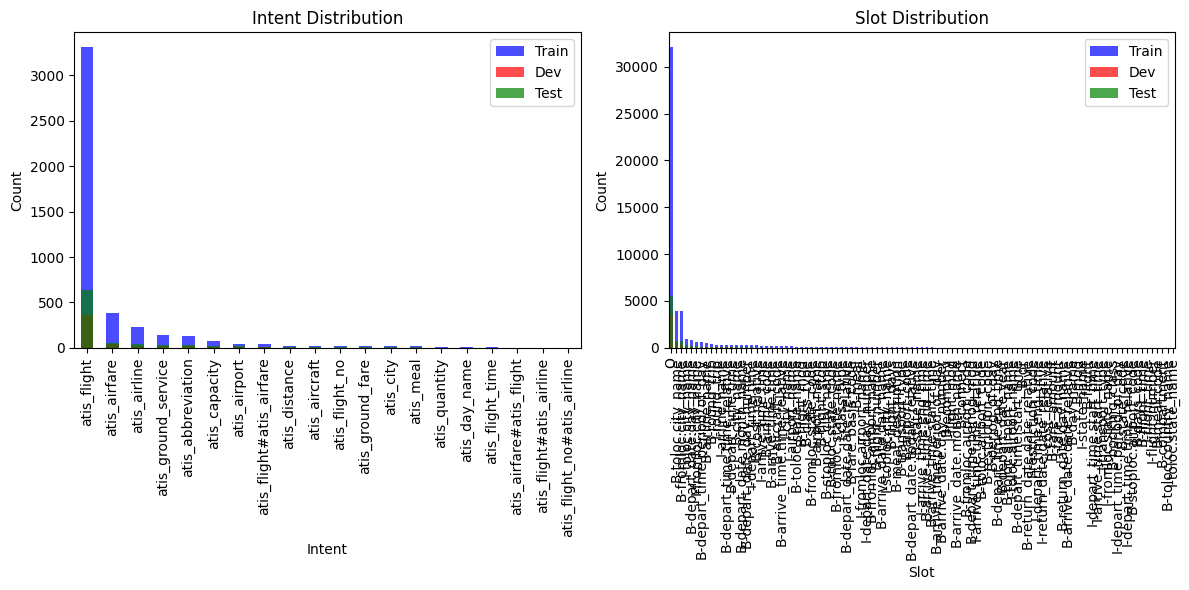

In [9]:
import matplotlib.pyplot as plt

# Convert lists to tuples
train_intent_slots = pd.DataFrame({'Intent': train_intents, 'Slots': [tuple(slots) for slots in train_slots]})
slot_labels_by_intent = train_intent_slots.groupby('Intent')['Slots'].apply(set)

print("\nSlot labels by Intent:")
for intent, slots in slot_labels_by_intent.items():
    print(intent, slots)

# Check if we have the same set of slot labels for each intent type
unique_slot_labels = set()
same_slot_labels = True

for slots in slot_labels_by_intent.values:
    if not unique_slot_labels:
        unique_slot_labels = slots
    elif unique_slot_labels != slots:
        same_slot_labels = False
        break

if same_slot_labels:
    print("\nAll intents have the same set of slot labels.")
else:
    print("\nIntents do not have the same set of slot labels.")

# Plotting statistics
plt.figure(figsize=(12, 6))

# Intent distribution bar plot
plt.subplot(1, 2, 1)
train_intent_counts.plot(kind='bar', color='blue', alpha=0.7, label='Train')
dev_intent_counts.plot(kind='bar', color='red', alpha=0.7, label='Dev')
test_intent_counts.plot(kind='bar', color='green', alpha=0.7, label='Test')
plt.title('Intent Distribution')
plt.xlabel('Intent')
plt.ylabel('Count')
plt.legend()

# Slot distribution bar plot
plt.subplot(1, 2, 2)
train_slot_counts.plot(kind='bar', color='blue', alpha=0.7, label='Train')
dev_slot_counts.plot(kind='bar', color='red', alpha=0.7, label='Dev')
test_slot_counts.plot(kind='bar', color='green', alpha=0.7, label='Test')
plt.title('Slot Distribution')
plt.xlabel('Slot')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()

#Here I loaded the slot filling data

In [10]:
#Extract unique slot labels from the training, dev, and test sets
trainslot_labels = sorted(set([s for sublist in train_slots for s in sublist]))
devslot_labels = sorted(set([s for sublist in dev_slots for s in sublist]))
testslot_labels = sorted(set([s for sublist in test_slots for s in sublist]))

Slotlabel = sorted(set(trainslot_labels + devslot_labels + testslot_labels))

print(Slotlabel)


['B-aircraft_code', 'B-airline_code', 'B-airline_name', 'B-airport_code', 'B-airport_name', 'B-arrive_date.date_relative', 'B-arrive_date.day_name', 'B-arrive_date.day_number', 'B-arrive_date.month_name', 'B-arrive_date.today_relative', 'B-arrive_time.end_time', 'B-arrive_time.period_mod', 'B-arrive_time.period_of_day', 'B-arrive_time.start_time', 'B-arrive_time.time', 'B-arrive_time.time_relative', 'B-booking_class', 'B-city_name', 'B-class_type', 'B-compartment', 'B-connect', 'B-cost_relative', 'B-day_name', 'B-day_number', 'B-days_code', 'B-depart_date.date_relative', 'B-depart_date.day_name', 'B-depart_date.day_number', 'B-depart_date.month_name', 'B-depart_date.today_relative', 'B-depart_date.year', 'B-depart_time.end_time', 'B-depart_time.period_mod', 'B-depart_time.period_of_day', 'B-depart_time.start_time', 'B-depart_time.time', 'B-depart_time.time_relative', 'B-economy', 'B-fare_amount', 'B-fare_basis_code', 'B-flight', 'B-flight_days', 'B-flight_mod', 'B-flight_number', 'B-fl

In [11]:
#Write the unique slot labels to a file in CoNLL format
Slotlabels_Conll = [f'"{label}",' for label in Slotlabel]
print(len(Slotlabels_Conll))

127


In [12]:

path = "/content/drive/MyDrive/atis-20230603T182700Z-001/atis/"
filename = "slot_labels_conll.txt"

with open(path+filename, "w", encoding="utf-8") as file:
    for element in Slotlabels_Conll:
        file.write(element + "\n")

In [13]:
def generate_conll_format(texts, slots, dataset):
    token_slots = []

    for i in range(len(texts)):
        token_slots.append("\n")
        for j in range(len(texts[i])):
            token_slot = texts[i][j] + "\t" + slots[i][j]
            token_slots.append(token_slot)

    if dataset == "train":
        return token_slots[1:]
    else:
        return token_slots



In [14]:
# Generate token-slot format for training set
train_token_slots = generate_conll_format(train_texts, train_slots,"train")
path = "/content/drive/MyDrive/atis-20230603T182700Z-001/atis/"
filename = "train_token_slots.txt"

with open(path+filename, "w", encoding="utf-8") as file:
    for element in train_token_slots:
        file.write(element + "\n")

In [15]:
# Generate token-slot format for validation set
val_token_slots = generate_conll_format(dev_texts, dev_slots,"dev")
path = '/content/drive/MyDrive/atis-20230603T182700Z-001/atis/'
filename = "dev_token_slots.txt"

with open(path+filename, "w", encoding="utf-8") as file:
    for element in val_token_slots:
        file.write(element + "\n")

In [16]:
#Generate token-slot format for test set
test_token_slots = generate_conll_format(test_texts, test_slots,"test")
path = '/content/drive/MyDrive/atis-20230603T182700Z-001/atis/'
filename = "test_token_slots.txt"

with open(path+filename, "w", encoding="utf-8") as file:
    for element in test_token_slots:
        file.write(element + "\n")

In [17]:
#Printing training, validation and testing slots data
print(train_token_slots)
print(test_token_slots)
print(val_token_slots)

['i\tO', 'want\tO', 'to\tO', 'fly\tO', 'from\tO', 'baltimore\tB-fromloc.city_name', 'to\tO', 'dallas\tB-toloc.city_name', 'round\tB-round_trip', 'trip\tI-round_trip', '\n', 'round\tB-round_trip', 'trip\tI-round_trip', 'fares\tO', 'from\tO', 'baltimore\tB-fromloc.city_name', 'to\tO', 'philadelphia\tB-toloc.city_name', 'less\tB-cost_relative', 'than\tO', '1000\tB-fare_amount', 'dollars\tI-fare_amount', 'round\tB-round_trip', 'trip\tI-round_trip', 'fares\tO', 'from\tO', 'denver\tB-fromloc.city_name', 'to\tO', 'philadelphia\tB-toloc.city_name', 'less\tB-cost_relative', 'than\tO', '1000\tB-fare_amount', 'dollars\tI-fare_amount', 'round\tB-round_trip', 'trip\tI-round_trip', 'fares\tO', 'from\tO', 'pittsburgh\tB-fromloc.city_name', 'to\tO', 'philadelphia\tB-toloc.city_name', 'less\tB-cost_relative', 'than\tO', '1000\tB-fare_amount', 'dollars\tI-fare_amount', '\n', 'show\tO', 'me\tO', 'the\tO', 'flights\tO', 'arriving\tO', 'on\tO', 'baltimore\tB-toloc.city_name', 'on\tO', 'june\tB-arrive_date.

#Here, I loaded the intent data

In [18]:
# Get the unique set of labels by combining train, dev, and test intents
labels = sorted(set(train_intents + dev_intents + test_intents))

#Print the unique labels and their count
print(labels)
print(len(labels))


['atis_abbreviation', 'atis_aircraft', 'atis_aircraft#atis_flight#atis_flight_no', 'atis_airfare', 'atis_airfare#atis_flight', 'atis_airfare#atis_flight_time', 'atis_airline', 'atis_airline#atis_flight_no', 'atis_airport', 'atis_capacity', 'atis_cheapest', 'atis_city', 'atis_day_name', 'atis_distance', 'atis_flight', 'atis_flight#atis_airfare', 'atis_flight#atis_airline', 'atis_flight_no', 'atis_flight_no#atis_airline', 'atis_flight_time', 'atis_ground_fare', 'atis_ground_service', 'atis_ground_service#atis_ground_fare', 'atis_meal', 'atis_quantity', 'atis_restriction']
26


In [19]:
# Create integer labels for the intents
integer_labels = list(range(len(labels)))
# Create mappings between integer labels and their corresponding string labels
integer_to_label = {i: label for i, label in enumerate(labels)}
label_to_integer = {label: i for i, label in enumerate(labels)}
#Print the integer labels, integer-to-label mapping, and label-to-integer mapping
print(integer_labels)
print(integer_to_label)
print(label_to_integer)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
{0: 'atis_abbreviation', 1: 'atis_aircraft', 2: 'atis_aircraft#atis_flight#atis_flight_no', 3: 'atis_airfare', 4: 'atis_airfare#atis_flight', 5: 'atis_airfare#atis_flight_time', 6: 'atis_airline', 7: 'atis_airline#atis_flight_no', 8: 'atis_airport', 9: 'atis_capacity', 10: 'atis_cheapest', 11: 'atis_city', 12: 'atis_day_name', 13: 'atis_distance', 14: 'atis_flight', 15: 'atis_flight#atis_airfare', 16: 'atis_flight#atis_airline', 17: 'atis_flight_no', 18: 'atis_flight_no#atis_airline', 19: 'atis_flight_time', 20: 'atis_ground_fare', 21: 'atis_ground_service', 22: 'atis_ground_service#atis_ground_fare', 23: 'atis_meal', 24: 'atis_quantity', 25: 'atis_restriction'}
{'atis_abbreviation': 0, 'atis_aircraft': 1, 'atis_aircraft#atis_flight#atis_flight_no': 2, 'atis_airfare': 3, 'atis_airfare#atis_flight': 4, 'atis_airfare#atis_flight_time': 5, 'atis_airline': 6, 'atis_airline#atis_flight_no': 7, 'at

In [20]:
#Convert the intents to integer labels
train_integer_labels = list(map(label_to_integer.get, train_intents))
dev_integer_labels = list(map(label_to_integer.get, dev_intents))
test_integer_labels = list(map(label_to_integer.get, test_intents))

In [21]:
#Function to convert a list of token lists to strings
def convert_to_strings(token_lists):
    strings = [' '.join(inner_list) for inner_list in token_lists]
    return strings


In [22]:
#Convert the token lists to strings
train_strings = convert_to_strings(train_texts)
dev_strings = convert_to_strings(dev_texts)
test_strings = convert_to_strings(test_texts)
# Print the converted strings
print(train_strings)
print(dev_strings)
print(test_strings)

['i want to fly from baltimore to dallas round trip', 'round trip fares from baltimore to philadelphia less than 1000 dollars round trip fares from denver to philadelphia less than 1000 dollars round trip fares from pittsburgh to philadelphia less than 1000 dollars', 'show me the flights arriving on baltimore on june fourteenth', 'what are the flights which depart from san francisco fly to washington via indianapolis and arrive by 9 pm', 'which airlines fly from boston to washington dc via other cities', "i'm looking for a flight from charlotte to las vegas that stops in st. louis hopefully a dinner flight how can i find that out", "okay and then from pittsburgh i'd like to travel to atlanta on september fourth", 'show me all the flights from philadelphia to cincinnati', "okay i'd like a flight on us air from indianapolis to san diego in the afternoon what's available", 'on tuesday what flights leave phoenix to st. paul minnesota and leave after noon', 'american flights from chicago to

In [23]:
# Create dataframes for train, validation, and test sets

dataframes_dict = {
    "train": pd.DataFrame({"label": train_integer_labels, "text": train_strings}),
    "dev": pd.DataFrame({"label": dev_integer_labels, "text": dev_strings}),
    "test": pd.DataFrame({"label": test_integer_labels, "text": test_strings})
}

# Assign the dataframes to variables
train_data_frame = dataframes_dict["train"]
dev_data_frame = dataframes_dict["dev"]
test_data_frame = dataframes_dict["test"]

In [24]:
# Print the head of train data frame
train_data_frame.head()

,label,text
0,14,i want to fly from baltimore to dallas round trip
1,3,round trip fares from baltimore to philadelphi...
2,14,show me the flights arriving on baltimore on j...
3,14,what are the flights which depart from san fra...
4,6,which airlines fly from boston to washington d...


In [25]:
# Print the head of validation dataframe
dev_data_frame.head()

,label,text
0,14,i want to fly from boston at 838 am and arrive...
1,14,show me all round trip flights between houston...
2,14,i would like some information on a flight from...
3,14,what are the coach flights between dallas and ...
4,14,i'm flying from boston to the bay area


In [26]:
#Print the head of test dataframe
test_data_frame.head()

,label,text
0,14,i would like to find a flight from charlotte t...
1,3,on april first i need a ticket from tacoma to ...
2,14,on april first i need a flight going from phoe...
3,14,i would like a flight traveling one way from p...
4,14,i would like a flight from orlando to salt lak...


## Preprocess

As we learn in class all the NLP task require some sort of preprocessing steps. The steps vary depending on the task as well as the type model we plan to use. That is, if our choice is to train a feature based ML model, then we probably would need more than tokenization (recall that based on the preprocessing we will build our set of features). As the goal of the assignment is not to exclusively focus on preprocessing, you can start tokenizating, lemmatizing and getting the PoS of each token. For this, you can any of the existing tool for NLP such as spaCy and NLTK.

On the contrary, if we plan to use DL for modeling our tasks, than preprocessing steps can be reduced to: 
- Tokenization
- Word indexing (and creation of the vocabulary)
- Converting text to sequence of word indexes (vectorization)
- Sequence padding if needed.

### TO-DO
- Preprare your data to feed your model.

In [27]:
!pip install datasets transformers seqeval evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 94.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 118.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 

In [28]:
from datasets import load_dataset, load_metric

In [32]:
#Define the path to the load_data script in the conll format

load_data = "/content/load_data.py"

#Define the paths to the train, val, and test data files
data_sets = {"train": "/content/drive/MyDrive/atis-20230603T182700Z-001/atis/train_token_slots.txt",
              "dev": "/content/drive/MyDrive/atis-20230603T182700Z-001/atis/dev_token_slots.txt",
              "test": "/content/drive/MyDrive/atis-20230603T182700Z-001/atis/test_token_slots.txt"}

# Load the dataset using the load_dataset function and the load_data script
dataset_slot = load_dataset(load_data, data_files=data_sets)


  0%|          | 0/3 [00:00<?, ?it/s]

#Preprocessed data for slot filling

In [33]:
## Check the number of instances in each split of the dataset
dataset_slot

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'slot_tags'],
        num_rows: 4478
    })
    validation: Dataset({
        features: ['id', 'tokens', 'slot_tags'],
        num_rows: 500
    })
    test: Dataset({
        features: ['id', 'tokens', 'slot_tags'],
        num_rows: 893
    })
})

In [34]:
#Access an example from the "train" split and print it
train_example = dataset_slot["train"][10]
print(train_example)

{'id': '10', 'tokens': ['american', 'flights', 'from', 'chicago', 'to', 'los', 'angeles', 'morning'], 'slot_tags': [2, 126, 126, 48, 126, 78, 123, 33]}


In [35]:
#Get the slot tags from the dataset's features
S_tags = dataset_slot["train"].features[f"slot_tags"].feature.names
print(S_tags)

['B-aircraft_code', 'B-airline_code', 'B-airline_name', 'B-airport_code', 'B-airport_name', 'B-arrive_date.date_relative', 'B-arrive_date.day_name', 'B-arrive_date.day_number', 'B-arrive_date.month_name', 'B-arrive_date.today_relative', 'B-arrive_time.end_time', 'B-arrive_time.period_mod', 'B-arrive_time.period_of_day', 'B-arrive_time.start_time', 'B-arrive_time.time', 'B-arrive_time.time_relative', 'B-booking_class', 'B-city_name', 'B-class_type', 'B-compartment', 'B-connect', 'B-cost_relative', 'B-day_name', 'B-day_number', 'B-days_code', 'B-depart_date.date_relative', 'B-depart_date.day_name', 'B-depart_date.day_number', 'B-depart_date.month_name', 'B-depart_date.today_relative', 'B-depart_date.year', 'B-depart_time.end_time', 'B-depart_time.period_mod', 'B-depart_time.period_of_day', 'B-depart_time.start_time', 'B-depart_time.time', 'B-depart_time.time_relative', 'B-economy', 'B-fare_amount', 'B-fare_basis_code', 'B-flight', 'B-flight_days', 'B-flight_mod', 'B-flight_number', 'B-fl

In [36]:

import transformers
from transformers import AutoTokenizer

#Load the tokenizer for the specified checkpoint
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint, add_prefix_space=True)
import transformers
#Verify that the tokenizer is an instance of PreTrainedTokenizerFast
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

In [37]:
# Set label_all_tokens to True
label_all_tokens = True

#Define a lambda function to tokenize and align the labels
tokenize_and_align_labels = lambda examples: (
    lambda tokenized_inputs: [
        tokenized_inputs.update(
            {
                "labels": [
                    [
                        (
                            lambda word_idx,
                            previous_word_idx=[None]: [
                                -100
                                if word_idx is None
                                else label[word_idx]
                                if word_idx != previous_word_idx[0]
                                else (label[word_idx] if label_all_tokens else -100),
                                previous_word_idx.__setitem__(0, word_idx)
                            ][0]
                        )(word_idx)
                        for word_idx in tokenized_inputs.word_ids(batch_index=i)
                    ]
                    for i, label in enumerate(examples["slot_tags"])
                ]
            }
        ),
        tokenized_inputs
    ][1]
)(tokenizer(examples["tokens"], truncation=True, is_split_into_words=True))

In [38]:
# Apply the tokenize_and_align_labels function to the first 3 examples in the dataset
tokenize_and_align_labels(dataset_slot["train"][:3])

{'input_ids': [[101, 1045, 2215, 2000, 4875, 2013, 6222, 2000, 5759, 2461, 4440, 102], [101, 2461, 4440, 27092, 2013, 6222, 2000, 4407, 2625, 2084, 6694, 6363, 2461, 4440, 27092, 2013, 7573, 2000, 4407, 2625, 2084, 6694, 6363, 2461, 4440, 27092, 2013, 6278, 2000, 4407, 2625, 2084, 6694, 6363, 102], [101, 2265, 2033, 1996, 7599, 7194, 2006, 6222, 2006, 2238, 15276, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[-100, 126, 126, 126, 126, 126, 48, 126, 78, 66, 117, -100], [-100, 66, 117, 126, 126, 48, 126, 78, 21, 126, 38, 102, 66, 117, 126, 126, 48, 126, 78, 21, 126, 38, 102, 66, 117, 126, 126, 48, 126, 78, 21, 126, 38, 102, -100], [-100, 126, 126, 126, 126, 126, 126, 78, 126, 8, 7, -100]]}

In [39]:
#Apply the tokenize_and_align_labels function to the first 3 examples in the dataset
slot_tokenized_dataset = dataset_slot.map(tokenize_and_align_labels, batched=True)
print(slot_tokenized_dataset)

Map:   0%|          | 0/4478 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/893 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'slot_tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 4478
    })
    validation: Dataset({
        features: ['id', 'tokens', 'slot_tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 500
    })
    test: Dataset({
        features: ['id', 'tokens', 'slot_tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 893
    })
})


#preprocessed data for intent classification.

In [40]:
#Convert the train, validation, and test dataframes into datasets using the `from_pandas` function from the `datasets` library
import datasets

train_dataset = datasets.Dataset.from_pandas(train_data_frame)
val_dataset = datasets.Dataset.from_pandas(dev_data_frame)
test_dataset = datasets.Dataset.from_pandas(test_data_frame)
#Print the train, validation, and test datasets
print(train_dataset)
print(val_dataset)
print(test_dataset)


Dataset({
    features: ['label', 'text'],
    num_rows: 4478
})
Dataset({
    features: ['label', 'text'],
    num_rows: 500
})
Dataset({
    features: ['label', 'text'],
    num_rows: 893
})


In [41]:
# Create a DatasetDict to store the train, validation, and test datasets
from datasets import Dataset, DatasetDict
data_dictionary = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})
# Print the data_dictionary containing the train, validation, and test datasets
data_dictionary

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 4478
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 500
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 893
    })
})

In [42]:
#Access an example from the "train" dataset in the data_dictionary and print it
train_dictionary = data_dictionary["train"][0]
print(train_dictionary)

{'label': 14, 'text': 'i want to fly from baltimore to dallas round trip'}


In [43]:
# Tokenize the text data using the "distilbert-base-uncased" tokenizer
checkpoint = "distilbert-base-uncased"
tokenizer_intent = AutoTokenizer.from_pretrained(checkpoint)

In [44]:
#Define a preprocess_function to tokenize the examples in the data_dictionary
preprocess_function = lambda examples: tokenizer_intent(examples["text"], truncation=True)

In [45]:
#Apply the preprocess_function to tokenize the intent tokens in the data_dictionary using the map() function
intent_tokens = data_dictionary.map(preprocess_function, batched=True)

Map:   0%|          | 0/4478 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/893 [00:00<?, ? examples/s]

In [46]:
#Access a tokenized example from the "train" dataset in the intent_tokens dictionary and print it
tokenized_data = intent_tokens["train"][0]
print(tokenized_data)

{'label': 14, 'text': 'i want to fly from baltimore to dallas round trip', 'input_ids': [101, 1045, 2215, 2000, 4875, 2013, 6222, 2000, 5759, 2461, 4440, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


## Build your models

Note that in to complete the assignment you have to be able to approach the two tasks, which typically they are approached in separated manner. _Intent classification_ can be cast as __text classification__, while _slot filling_ is usually approached as a __squence labeling__ task. 
The simplest solution is to create two models, where we learn each task separately. Optionaly, you can define a joint model in which both tasks are learned at the same time. 

The following code shows the set of methods that models should contain.

- `__init__`: You can use the initialization method (or constructor) to set the hyperparameters of the model.
- `fit`: Method that takes care of the training. Tipically it takes training and validation data as input.
- `predict`: Given the test data it returns the predictions of the model.

In the case you are using a Python library like `Scikit-learn` you really don't need to use the code snippets provided below. Then you can directly load your ML object. 

### TO-DO

- Generate the code to build the models that are able to approach the inten classification  and slot filling tasks.
- You can reused the code used in the other labs. 



In [47]:
#Uninstall and reinstall the transformers and accelerate libraries
!pip uninstall -y transformers accelerate
!pip install transformers accelerate

Found existing installation: transformers 4.29.2
Uninstalling transformers-4.29.2:
  Successfully uninstalled transformers-4.29.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.29.2-py3-none-any.whl (7.1 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 6.8 MB/s eta 0:00:00


#Model for slot filling

In [48]:
# Import necessary libraries
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
from datasets import load_metric
import numpy as np

In [49]:
# Load the slot_model for token classification from the pretrained checkpoint
slot_model = AutoModelForTokenClassification.from_pretrained(checkpoint, num_labels=len(S_tags))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForTokenClassification: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN t

In [50]:
# Set the batch size for slot training
slot_batch_size = 15
# Define the training arguments for slot training
slot_arg = TrainingArguments(
    f"/content/drive/MyDrive/atis-20230603T182700Z-001/atis",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size= slot_batch_size,
    per_device_eval_batch_size= slot_batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
)

In [51]:
#from transformers import DataCollatorForTokenClassification
# Create the data collator for token classification using the tokenizer
slot_data_collator = DataCollatorForTokenClassification(tokenizer)

In [52]:
# Load the seqeval metric for evaluation
metric_slot = load_metric("seqeval")

<ipython-input-52-57ea37d0d78c>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric_slot = load_metric("seqeval")


In [53]:
# Define the slot_compute_metric function to compute metrics from predictions
def slot_compute_metric(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=2)

    True_Predictions = []
    True_Labels = []
    for prediction, label in zip(predictions, labels):
        F_predictions = []
        F_labels = []
        for pred, l in zip(prediction, label):
            if l != -100:
                F_predictions.append(S_tags[pred])
                F_labels.append(S_tags[l])
        True_Predictions.append(F_predictions)
        True_Labels.append(F_labels)

    Final_results = metric_slot.compute(predictions=True_Predictions, references=True_Labels)
    return {
        "precision": Final_results["overall_precision"],
        "recall": Final_results["overall_recall"],
        "f1": Final_results["overall_f1"],
        "accuracy": Final_results["overall_accuracy"],
    }


In [54]:
# Create the Trainer for slot training
Slot_trainer = Trainer(
    slot_model,
    slot_arg,
    train_dataset= slot_tokenized_dataset["train"],
    eval_dataset= slot_tokenized_dataset["validation"],
    data_collator= slot_data_collator,
    tokenizer=tokenizer,
    compute_metrics= slot_compute_metric
)

# Model for intent classification

In [55]:
# Import the DataCollatorWithPadding from transformers
from transformers import DataCollatorWithPadding
# Create a data collator with padding using the intent tokenizer
data_collator = DataCollatorWithPadding(tokenizer=tokenizer_intent)

In [56]:
# Import evaluation metrics from the evaluate module
import evaluate
# Load evaluation metrics
accuracy = evaluate.load("accuracy")
Precision = evaluate.load("precision")
Recall = evaluate.load("recall")
F1 = evaluate.load("f1")

In [57]:
# Import evaluation metrics from scikit-learn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Define a function to compute intent metrics
def metrics_intent(eval_pred):
 predictions, labels = eval_pred
 predictions = np.argmax(predictions, axis=1)
 accuracy = accuracy_score(labels, predictions)
 precision = precision_score(labels, predictions, average='weighted')
 recall = recall_score(labels, predictions, average='weighted')
 f1 = f1_score(labels, predictions, average='weighted')
 return {
 'accuracy': accuracy,
 'precision': precision,
 'recall': recall,
 'f1_score': f1,
 }


In [58]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
# Load the intent_model for sequence classification from the pretrained checkpoint
intent_model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=len(labels), id2label= integer_to_label, label2id=label_to_integer)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

In [59]:
# Set the batch size for intent training
intent_batch = 15
# Define the training arguments for intent training
training_args_intent = TrainingArguments(
    f"/content/drive/MyDrive/atis-20230603T182700Z-001/atis",
    learning_rate=2e-5,
    per_device_train_batch_size=intent_batch,
    per_device_eval_batch_size=intent_batch,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
)

In [60]:
# Create the Trainer for intent training
intent_trainer = Trainer(
    model=intent_model,
    args=training_args_intent,
    train_dataset=intent_tokens["train"],
    eval_dataset=intent_tokens["validation"],
    tokenizer=tokenizer_intent,
    data_collator=data_collator,
    compute_metrics=metrics_intent,
)

In [61]:
# Print the slot_tokenized_dataset and intent_tokens
print(slot_tokenized_dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'slot_tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 4478
    })
    validation: Dataset({
        features: ['id', 'tokens', 'slot_tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 500
    })
    test: Dataset({
        features: ['id', 'tokens', 'slot_tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 893
    })
})


In [62]:
# Print the intent_tokens
print(intent_tokens)

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 4478
    })
    validation: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 500
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 893
    })
})


## Train, validate and evaluate

__Training__

Once you defined your model, and loaded and preprocessed the data, you just need to train it.  Depending on your model choice, you might need to extract the features (and vectorize the examples) before you fit your model. 

Be aware that in this phase we can explore and tune the hyperparameter values of our model. Note that we are not allowed to use the test partition for that. All the development of our approach is done on training and development paritions. 

__Evaluation__

Once you fit the model and you are happy with your results obtained in the validation part, you can move to evaluate the model on the test part. 
 Note that you have to choose a set of useful evaluation __metrics__. Typically, we use precision, recall, and f1-score, and you can use  For that you can use the functions in `sklearn.metrics` modules.  If you are using `tensorflow` or `pytorch` you can their buil-in metrics for the evaluation.

### TO-DO
- Fit and tune your model using the training and development partition.
- Make clear in the code how you tune your model. 
- Evaluate it on the test set.



#Training the model on slot

In [63]:
#Train the slot model
Slot_trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.259228,0.869590,0.868126,0.868857,0.950145
2,0.536200,0.131998,0.934041,0.937710,0.935872,0.977540
3,0.536200,0.096963,0.949332,0.956790,0.953046,0.984686
4,0.109000,0.084223,0.959709,0.962402,0.961054,0.986728
5,0.109000,0.080691,0.964146,0.965769,0.964957,0.987749


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=1495, training_loss=0.2385295472416192, metrics={'train_runtime': 117.952, 'train_samples_per_second': 189.823, 'train_steps_per_second': 12.675, 'total_flos': 134064814402410.0, 'train_loss': 0.2385295472416192, 'epoch': 5.0})

In [64]:
#Evaluate the slot model on the development set
Slot_trainer.evaluate()

{'eval_loss': 0.08069097995758057,
 'eval_precision': 0.9641456582633053,
 'eval_recall': 0.9657687991021324,
 'eval_f1': 0.9649565461171854,
 'eval_accuracy': 0.9877488514548239,
 'eval_runtime': 0.5335,
 'eval_samples_per_second': 937.247,
 'eval_steps_per_second': 63.733,
 'epoch': 5.0}

In [65]:
# Make predictions using the slot model on the test set
slot_pred, slot_label, _ = Slot_trainer.predict(slot_tokenized_dataset["test"])
slot_pred = np.argmax(slot_pred, axis=2)


actual_slot_pred = []
actual_labels_slot = []
# Filter out padding tokens and convert predictions and labels to slot tags
for prediction, label in zip(slot_pred, slot_label):
    filtered_predictions = []
    filtered_labels = []
    for p, l in zip(prediction, label):
        if l != -100:
            filtered_predictions.append(S_tags[p])
            filtered_labels.append(S_tags[l])
    actual_slot_pred.append(filtered_predictions)
    actual_labels_slot.append(filtered_labels)
# Compute slot metrics using the seqeval library
result_slot = metric_slot.compute(predictions=actual_slot_pred, references=actual_labels_slot)
result_slot

{'aircraft_code': {'precision': 1.0,
  'recall': 0.9130434782608695,
  'f1': 0.9545454545454545,
  'number': 69},
 'airline_code': {'precision': 0.7647058823529411,
  'recall': 0.9069767441860465,
  'f1': 0.8297872340425532,
  'number': 43},
 'airline_name': {'precision': 0.9811320754716981,
  'recall': 1.0,
  'f1': 0.9904761904761905,
  'number': 104},
 'airport_code': {'precision': 0.42857142857142855,
  'recall': 0.16666666666666666,
  'f1': 0.24,
  'number': 18},
 'airport_name': {'precision': 0.8,
  'recall': 0.38095238095238093,
  'f1': 0.5161290322580645,
  'number': 21},
 'arrive_date.date_relative': {'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0,
  'number': 2},
 'arrive_date.day_name': {'precision': 0.7692307692307693,
  'recall': 0.9090909090909091,
  'f1': 0.8333333333333333,
  'number': 11},
 'arrive_date.day_number': {'precision': 1.0,
  'recall': 0.8333333333333334,
  'f1': 0.9090909090909091,
  'number': 6},
 'arrive_date.month_name': {'precision': 0.7142857142857143,


In [66]:
# Train the intent model
intent_trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,No log,0.304306,0.940000,0.922181,0.940000,0.928511
2,0.492900,0.190537,0.968000,0.960321,0.968000,0.962929
3,0.492900,0.178437,0.968000,0.960916,0.968000,0.962730


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=897, training_loss=0.3161857715551404, metrics={'train_runtime': 59.5455, 'train_samples_per_second': 225.609, 'train_steps_per_second': 15.064, 'total_flos': 81560298016896.0, 'train_loss': 0.3161857715551404, 'epoch': 3.0})

In [67]:
# Evaluate the intent model on the validation set
intent_trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.17843742668628693,
 'eval_accuracy': 0.968,
 'eval_precision': 0.9609157235308551,
 'eval_recall': 0.968,
 'eval_f1_score': 0.9627304957115007,
 'eval_runtime': 0.5205,
 'eval_samples_per_second': 960.686,
 'eval_steps_per_second': 65.327,
 'epoch': 3.0}

In [68]:
# Evaluate the intent model on the test set
intent_trainer.evaluate(eval_dataset=intent_tokens["test"])

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.27767592668533325,
 'eval_accuracy': 0.9608062709966405,
 'eval_precision': 0.9549838806647191,
 'eval_recall': 0.9608062709966405,
 'eval_f1_score': 0.9542505894889133,
 'eval_runtime': 0.7266,
 'eval_samples_per_second': 1228.963,
 'eval_steps_per_second': 82.573,
 'epoch': 3.0}

## Analysis of the output
It is important to run some analysis of the output of our model in order to gain some insights about good and bad things of the model. A good idea is to extract some correct examples and incorrectly predicted examples. For the slot filing task you can use [the spaCy visualizer for entities](https://spacy.io/usage/visualizers). A example of how to use it you can find in the notebook of __lab 2 (NER with spaCy)__.

In addition, the calculation of a confusion matrix it is very helpful to depict the type of prediction error. It helps to see if there a bias towards a specific set of labels, or there exist some kind confusability between classes (e.g. because class definitions are similar) and so on.  You can find in `scikit-learn` a module to calculate confusion matrices (`sklearn.metrics.confusion_matrix`)

### TO-DO 
- Show some correct and incorrect examples for intent classification and slot filling. 
- Calculate on the development set and show the confusion matrix of your model. 


In [69]:
# Evaluate the slot model on the development set
predictions_slot, labels_slot, _ = Slot_trainer.predict(slot_tokenized_dataset["validation"])
predictions_slot = np.argmax(predictions_slot, axis=2)

# Remove ignored index (special tokens) and convert predictions and labels to slot tags
true_predictions_slot = []
true_labels_slot = []
for prediction, label in zip(predictions_slot, labels_slot):
    true_prediction = []
    true_label = []
    for p, l in zip(prediction, label):
        if l != -100:
            true_prediction.append(S_tags[p])
            true_label.append(S_tags[l])
    true_predictions_slot.append(true_prediction)
    true_labels_slot.append(true_label)
# Compute slot metrics using the seqeval library
results_slot = metric_slot.compute(predictions=true_predictions_slot, references=true_labels_slot)


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [70]:
# Get two lists with correctly and incorrectly classified tokens
correct_examples = [
    f"Pred.: {pred} == True: {true}"
    for preds, trues in zip(true_predictions_slot, true_labels_slot)
    for pred, true in zip(preds, trues)
    if pred == true
]
incorrect_examples = [
    f"Pred.: {pred} != True: {true}"
    for preds, trues in zip(true_predictions_slot, true_labels_slot)
    for pred, true in zip(preds, trues)
    if pred != true
]


In [71]:
# Print the correctly classified tokens
print(correct_examples)

['Pred.: O == True: O', 'Pred.: O == True: O', 'Pred.: O == True: O', 'Pred.: O == True: O', 'Pred.: O == True: O', 'Pred.: B-fromloc.city_name == True: B-fromloc.city_name', 'Pred.: O == True: O', 'Pred.: B-depart_time.time == True: B-depart_time.time', 'Pred.: B-depart_time.time == True: B-depart_time.time', 'Pred.: I-depart_time.time == True: I-depart_time.time', 'Pred.: O == True: O', 'Pred.: O == True: O', 'Pred.: O == True: O', 'Pred.: B-toloc.city_name == True: B-toloc.city_name', 'Pred.: O == True: O', 'Pred.: B-arrive_time.time == True: B-arrive_time.time', 'Pred.: B-arrive_time.time == True: B-arrive_time.time', 'Pred.: O == True: O', 'Pred.: O == True: O', 'Pred.: B-arrive_time.period_of_day == True: B-arrive_time.period_of_day', 'Pred.: O == True: O', 'Pred.: O == True: O', 'Pred.: O == True: O', 'Pred.: B-round_trip == True: B-round_trip', 'Pred.: I-round_trip == True: I-round_trip', 'Pred.: O == True: O', 'Pred.: O == True: O', 'Pred.: B-fromloc.city_name == True: B-froml

In [72]:
# Print the incorrectly classified tokens
print(incorrect_examples)

['Pred.: B-depart_date.month_name != True: B-return_date.month_name', 'Pred.: B-depart_date.day_number != True: B-return_date.day_number', 'Pred.: B-toloc.city_name != True: B-toloc.state_name', 'Pred.: B-toloc.city_name != True: B-toloc.airport_name', 'Pred.: B-toloc.city_name != True: B-toloc.airport_name', 'Pred.: I-toloc.city_name != True: B-toloc.airport_name', 'Pred.: O != True: B-depart_time.period_of_day', 'Pred.: B-depart_time.period_mod != True: O', 'Pred.: B-depart_time.period_of_day != True: B-return_time.period_of_day', 'Pred.: B-depart_date.month_name != True: B-return_date.month_name', 'Pred.: B-depart_date.day_number != True: B-return_date.day_number', 'Pred.: I-depart_date.day_number != True: I-return_date.day_number', 'Pred.: B-depart_time.period_of_day != True: B-arrive_time.period_of_day', 'Pred.: I-class_type != True: O', 'Pred.: B-flight_mod != True: O', 'Pred.: B-arrive_time.time != True: B-arrive_time.period_of_day', 'Pred.: B-depart_date.day_name != True: B-day

In [73]:
# Function to flatten a list of lists
def flatten_list(list_of_lists):
    flattened_list = []
    for sublist in list_of_lists:
        for element in sublist:
            flattened_list.append(element)
    return flattened_list

In [74]:
# Flatten the lists of true labels and predictions
true_labels_slot_list = flatten_list(true_labels_slot)
true_predictions_slot_list = flatten_list(true_predictions_slot)

In [75]:
# Compute the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix_slot = confusion_matrix(true_labels_slot_list, true_predictions_slot_list, labels=Slotlabel)
confusion_matrix_slot

array([[   1,    0,    0, ...,    0,    0,    0],
       [   0,   10,    0, ...,    0,    0,    0],
       [   0,    0,   64, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ...,    1,    0,    0],
       [   0,    0,    0, ...,    0,    2,    0],
       [   0,    0,    0, ...,    0,    0, 3673]])

In [76]:
# Function to remove prefix from slot labels
def delete_slotlabels(some_list):
  return [x.split('-')[-1] if x != 'O' else x for x in some_list ]

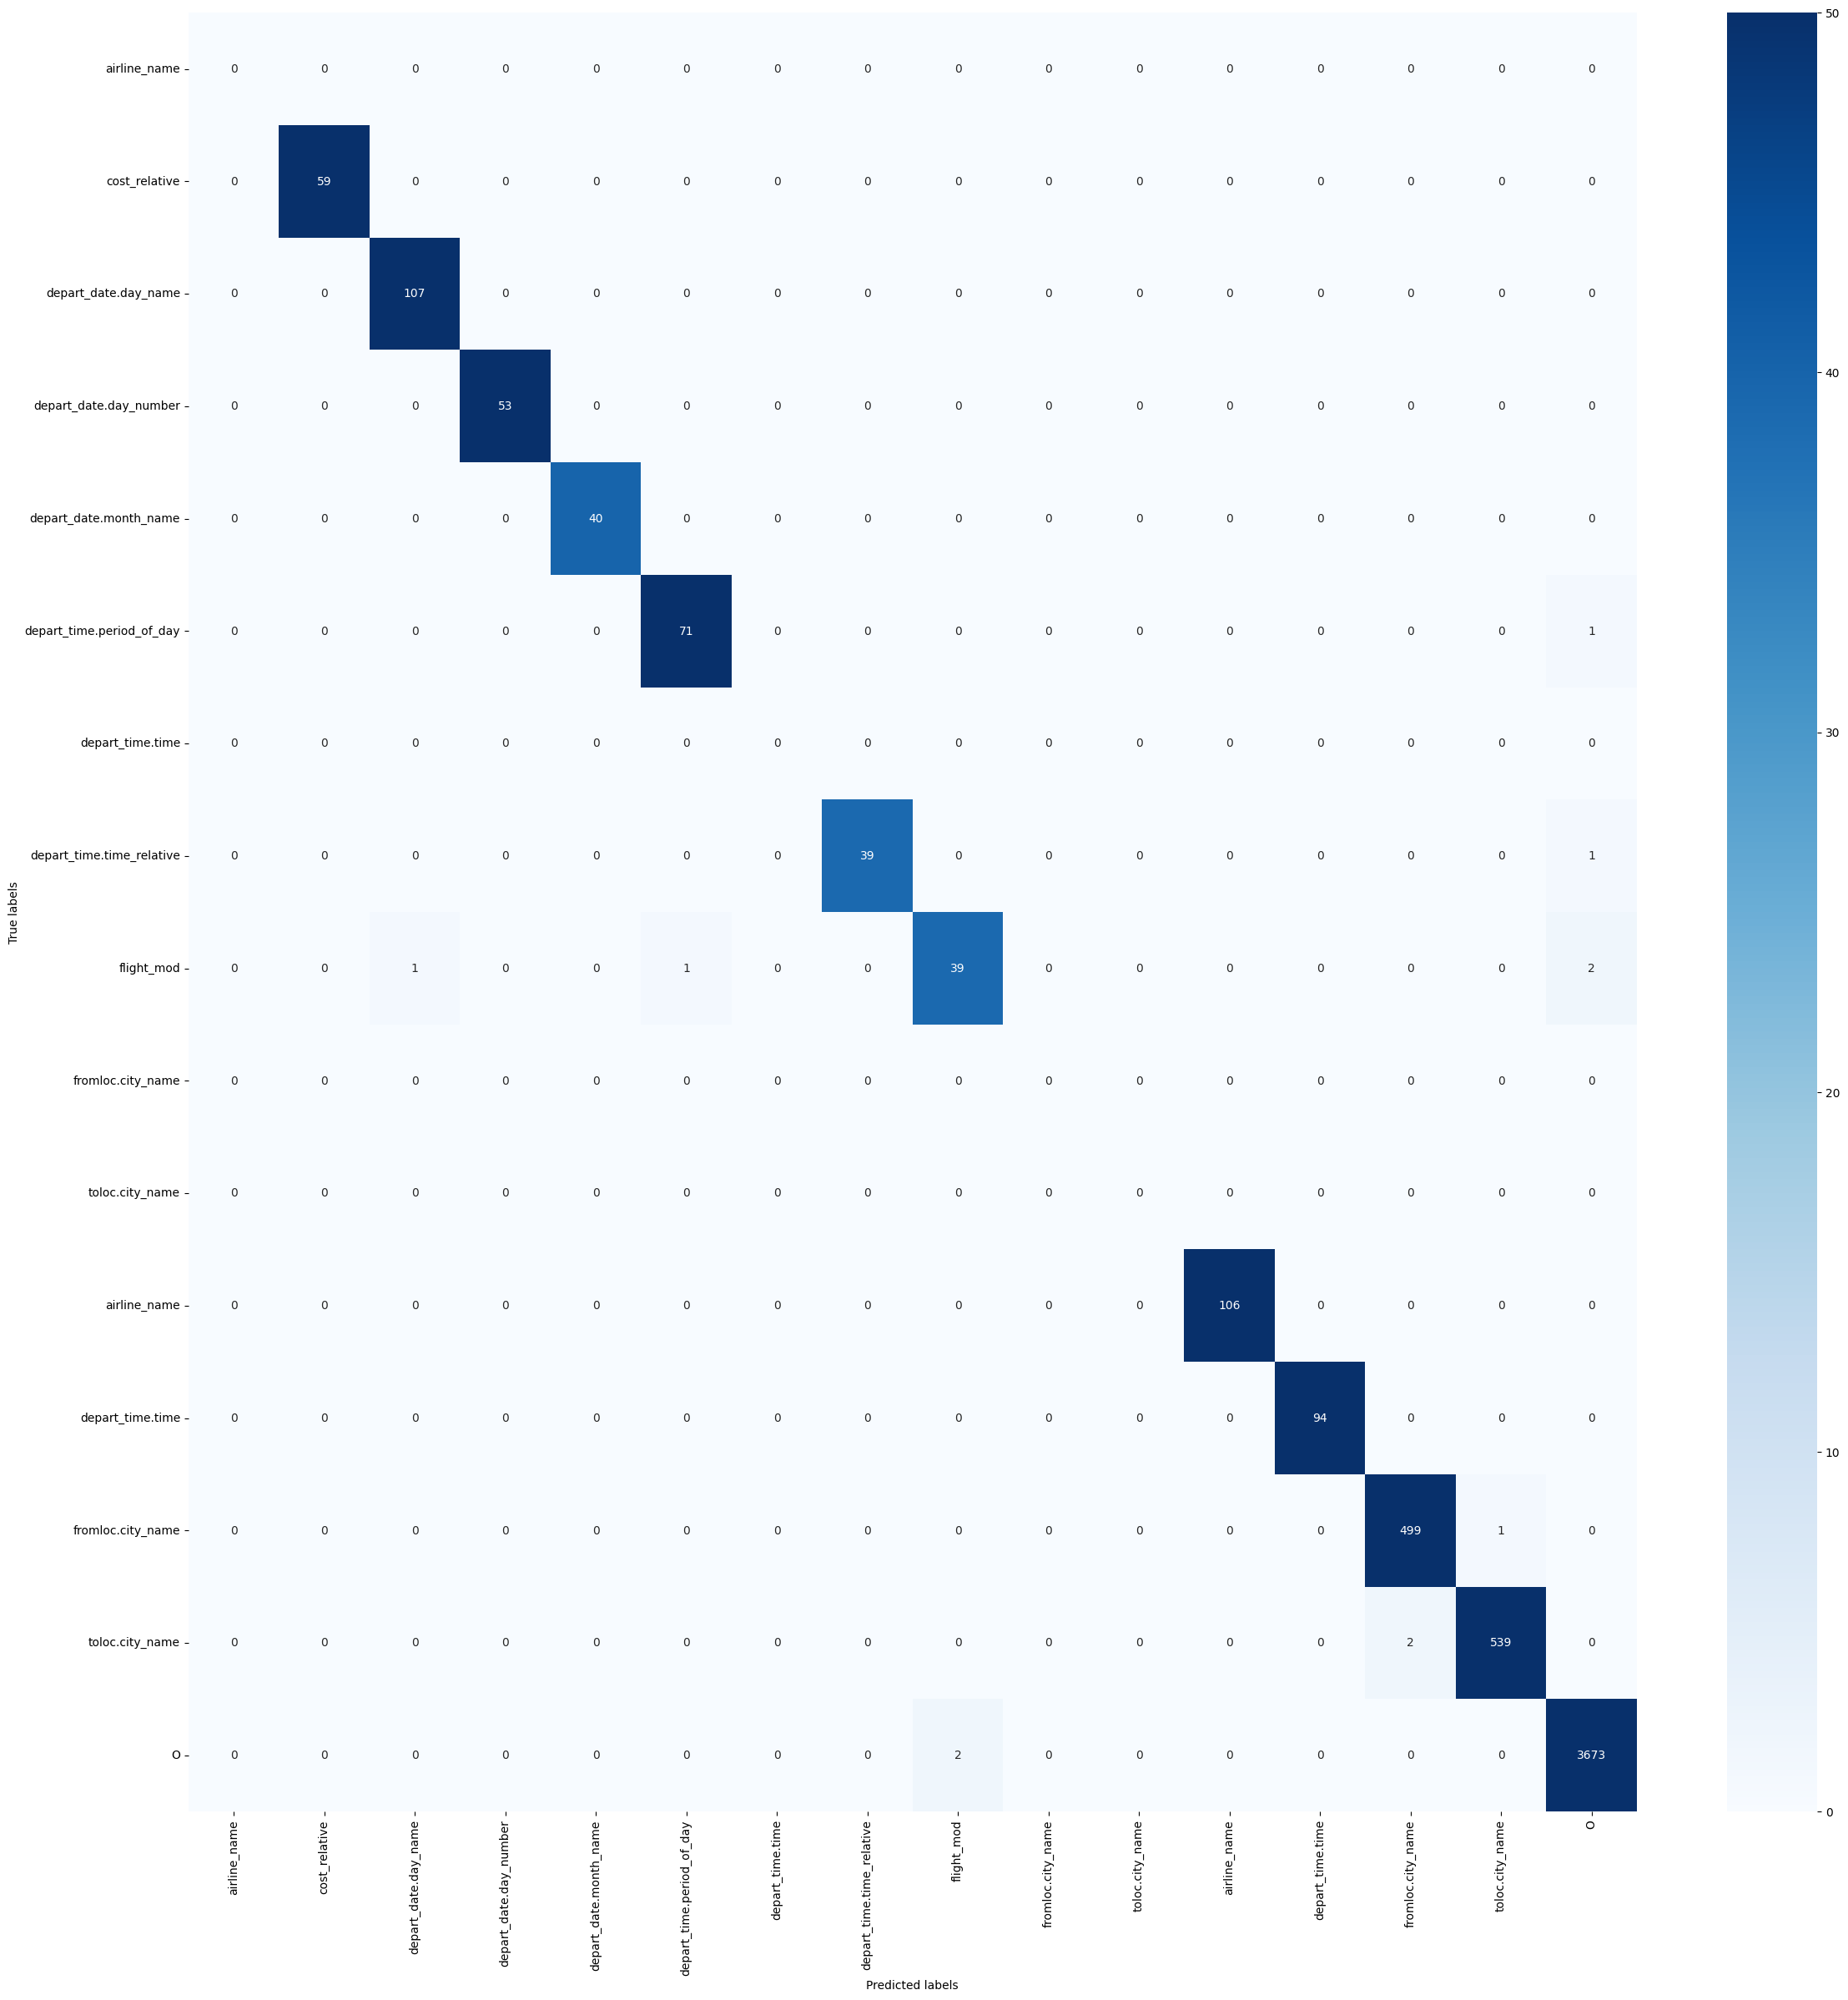

In [77]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Identify columns with values less than 10
cols_less_than_10 = np.where(confusion_matrix_slot.sum(axis=0) < 30)[0]

# Get the labels that are not predicted at least 10 times
labels_not_predicted_10 = [Slotlabel[i] for i in cols_less_than_10]


# Create a new list of labels that excludes the labels in the labels_not_predicted list
new_labels = [label for label in Slotlabel if label not in labels_not_predicted_10]

# Calculate the new confusion matrix
new_confusion_matrix_slot = confusion_matrix(
    delete_slotlabels(true_labels_slot_list),
    delete_slotlabels(true_predictions_slot_list),
    labels=delete_slotlabels(new_labels),
)

# Plot the new confusion matrix
plt.figure(figsize=(28, 28))
sns.heatmap(
    new_confusion_matrix_slot,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=delete_slotlabels(new_labels),
    yticklabels=delete_slotlabels(new_labels),
    vmax=50,
)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


In [78]:
from transformers import pipeline

# Load the trained intent model
model_intent_pipeline = pipeline(
 "text-classification",
 model="/content/drive/MyDrive/atis-20230603T182700Z-001/atis/checkpoint-840",
 tokenizer=tokenizer_intent
)

# generate predictions for the validation split
intent_text = dev_strings
intent_actual_labels = dev_intents
predicted_intents = model_intent_pipeline(intent_text)

# Compare the predictions with the true labels
correct_intent = [[text, prediction, true_label] for text, prediction, true_label in zip(intent_text, predicted_intents, intent_actual_labels) if prediction["label"] == true_label]
incorrect_intent = [[text, prediction, true_label] for text, prediction, true_label in zip(intent_text, predicted_intents, intent_actual_labels) if prediction["label"] != true_label]

print(f"Correctly_classified_intents: {correct_intent}")
print(f"Incorrectly_classified_intents: {incorrect_intent}")


Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


Correctly_classified_intents: [['i want to fly from boston at 838 am and arrive in denver at 1110 in the morning', {'label': 'atis_flight', 'score': 0.9984169006347656}, 'atis_flight'], ['show me all round trip flights between houston and las vegas', {'label': 'atis_flight', 'score': 0.9985234141349792}, 'atis_flight'], ['i would like some information on a flight from denver to san francisco on united airlines', {'label': 'atis_flight', 'score': 0.9984573125839233}, 'atis_flight'], ['what are the coach flights between dallas and baltimore leaving august tenth and returning august twelve', {'label': 'atis_flight', 'score': 0.998310923576355}, 'atis_flight'], ["i'm flying from boston to the bay area", {'label': 'atis_flight', 'score': 0.9981821775436401}, 'atis_flight'], ['from montreal to las vegas', {'label': 'atis_flight', 'score': 0.9982208609580994}, 'atis_flight'], ['what is the earliest breakfast flight from philadelphia to fort worth', {'label': 'atis_flight', 'score': 0.99842631

In [79]:
# get the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix_intent = confusion_matrix(intent_actual_labels, [p["label"] for p in predicted_intents], labels=labels)

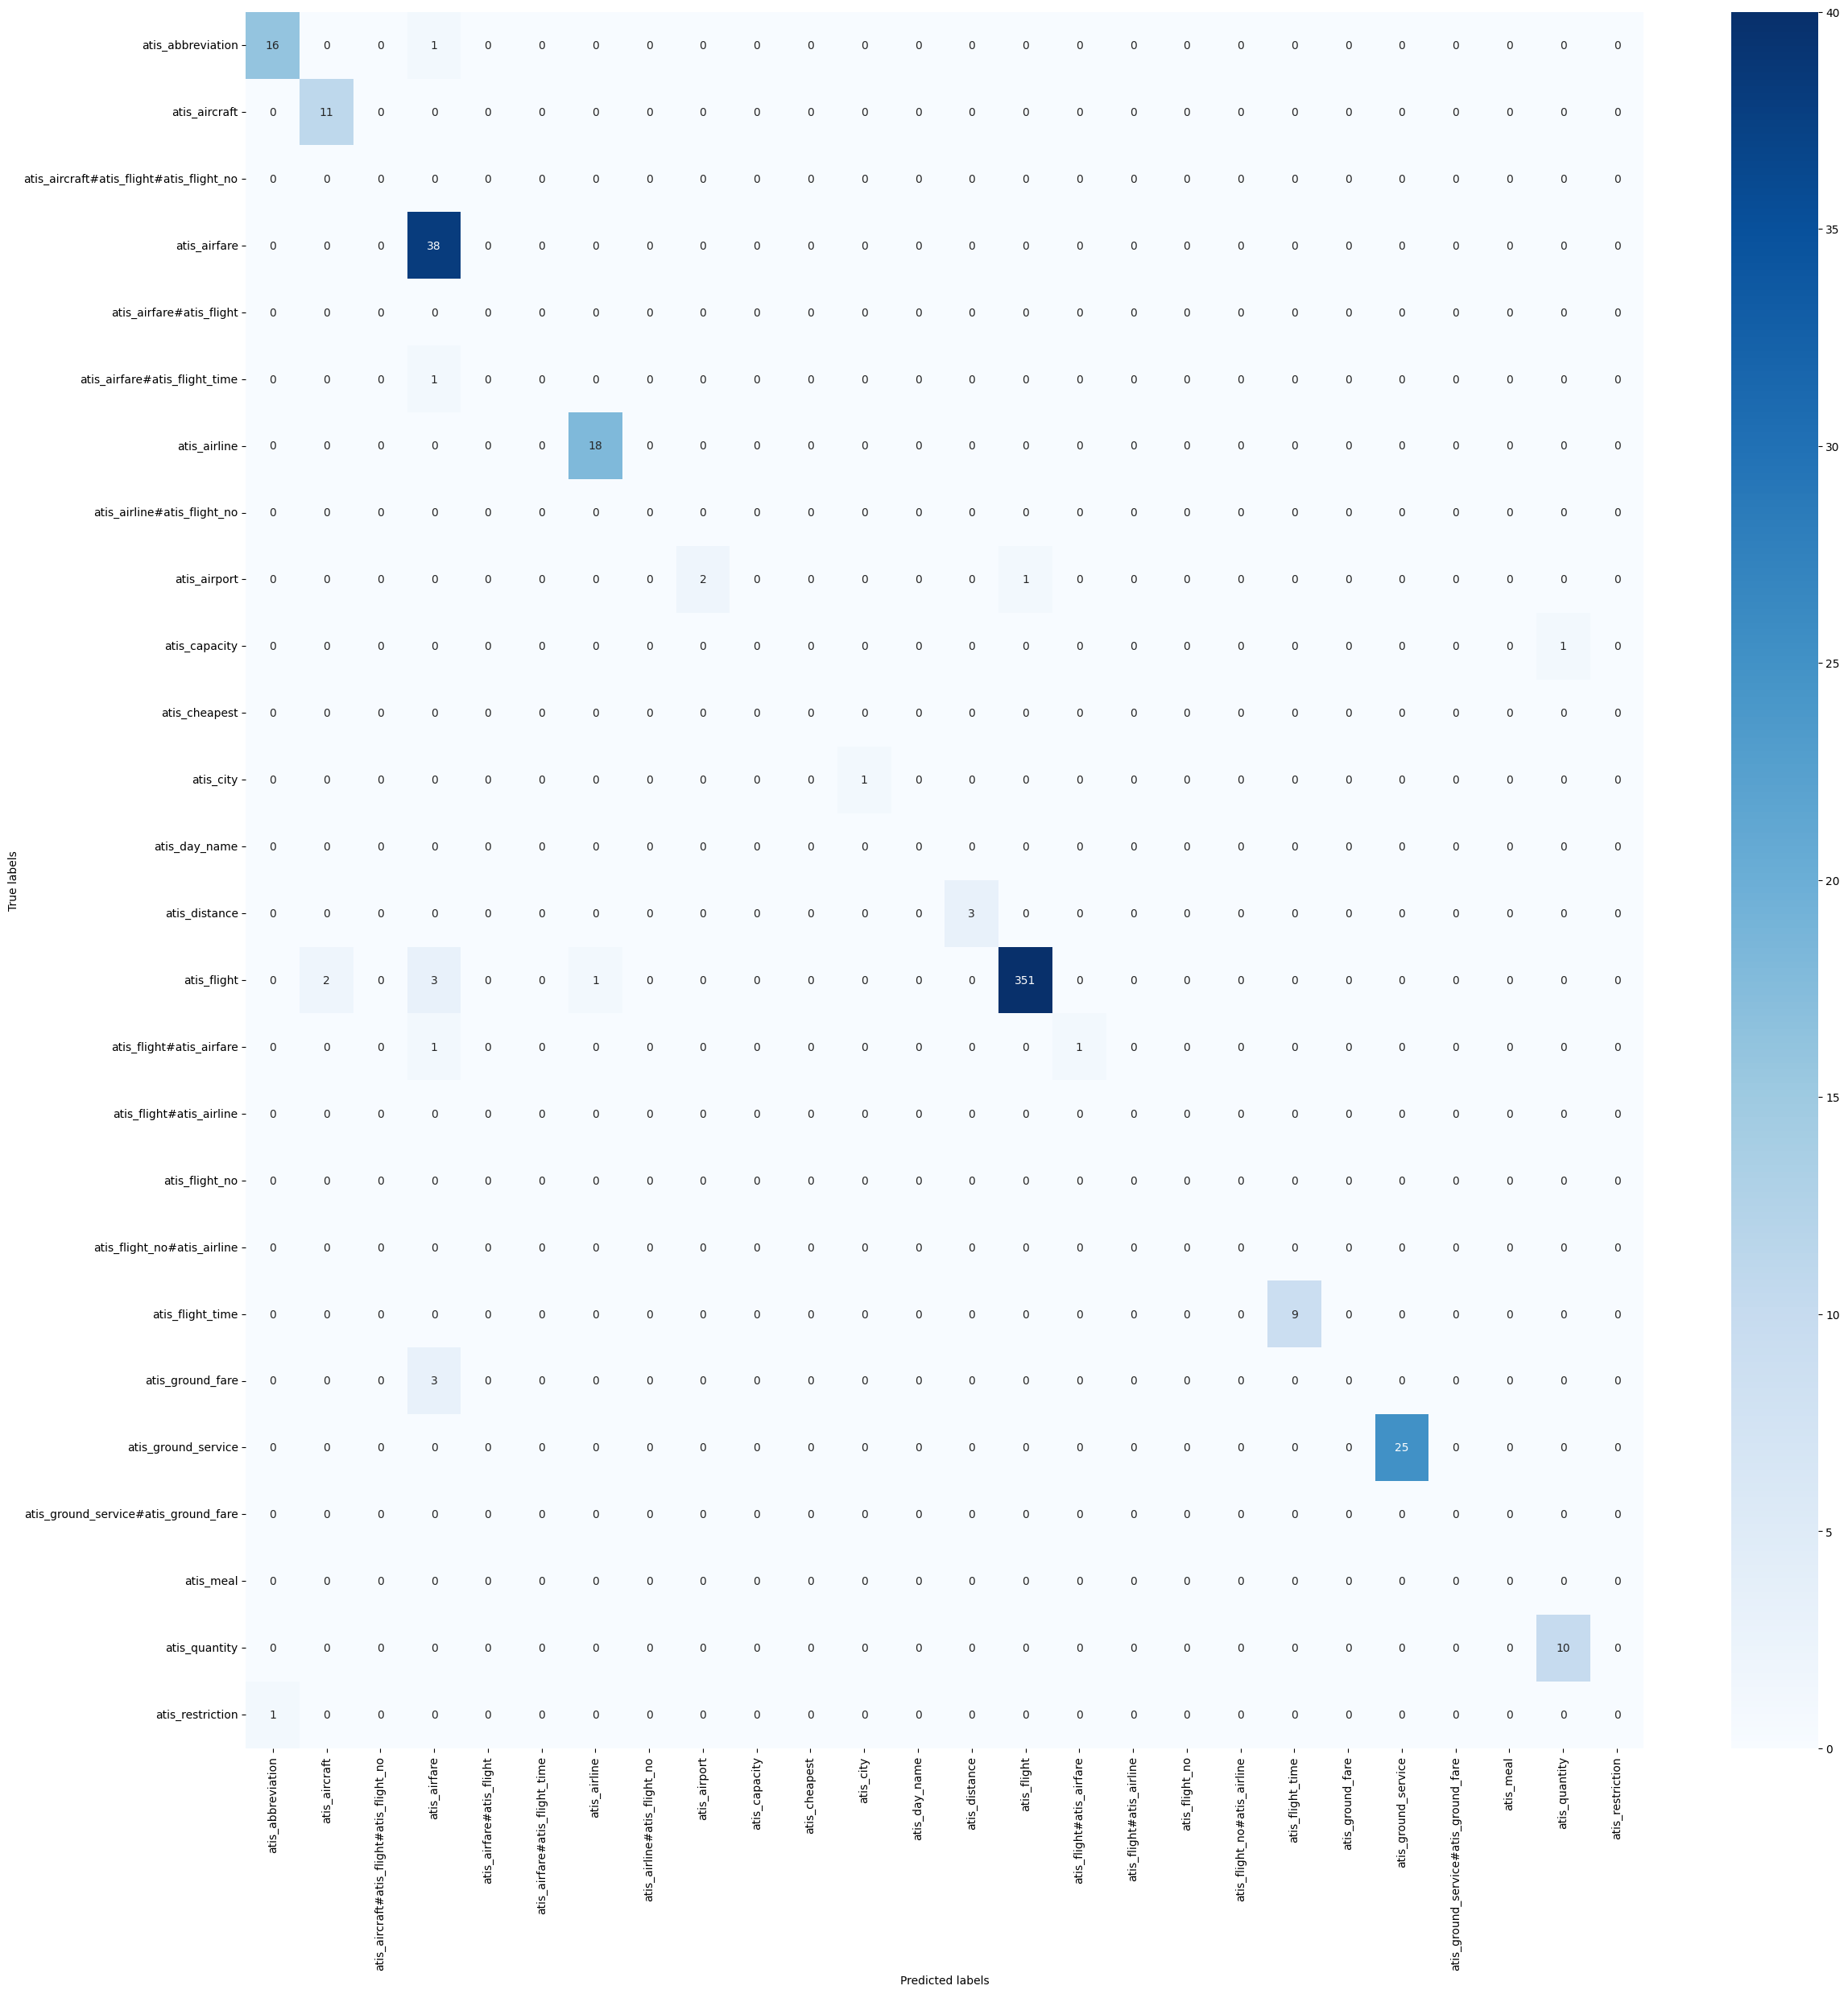

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the new confusion matrix using seaborn and matplotlib
plt.figure(figsize=(28, 28))
sns.heatmap(confusion_matrix_intent, annot=True, fmt='d', cmap='Blues',xticklabels=labels,yticklabels=labels,vmax=40)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
